## Dependencies

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
import pandas as pd
from download import download_data_and_parse_it
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import train_test_split
import time
import os

from sklearn.metrics import accuracy_score

batch_size = 32
num_classes = 23
learning_rate = 0.001
# learning_rate = 0.001168
num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Create the dataset

In [3]:
# Load the JSON file into a DataFrame
datasets = [
        "star", "sword", "tent", "apple", "banana", "cat", 
        "dog", "car", "house", "tree", "guitar", "bicycle", "wine bottle", "bench", "pencil",
        "elbow", "t-shirt", "hammer", "moon", "umbrella", "ice cream", "sailboat", "fish"
    ]
    
all_dfs = []  # List to store all DataFrames
for dataset in datasets:
    file_path = os.path.join("data", f"{dataset}.ndjson")
    dataset_df = download_data_and_parse_it(file_path)
    all_dfs.append(dataset_df)
# Combine all datasets
df = pd.concat(all_dfs, ignore_index=True)

# Assign class labels using LabelEncoder
le = LabelEncoder()
df['class'] = le.fit_transform(df['word'])

word_class_mapping = df[['word', 'class']].drop_duplicates().sort_values('class').to_numpy()

# Display the array
print(word_class_mapping)

# Split into training, validation, and testing sets
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)  # 60% train, 40% temp
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # Split temp into 20% val, 20% test

print("size of datasets array :", len(datasets))

The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
[['apple' 0]
 ['banana' 1]
 ['bench' 2]
 ['bicycle' 3]
 ['car' 4]
 ['cat' 5]
 ['dog' 6]
 ['elbow' 7]
 ['fish' 8]
 ['guitar' 9]
 ['hammer' 10]
 ['house' 11]
 ['ice cream' 12]
 ['moon' 13]
 ['pencil' 14]
 ['sailboat' 15]
 ['star' 16]
 ['sword' 17]
 ['t-shirt' 18]
 ['tent' 19]
 ['tree' 20]
 ['umbrella' 21]
 ['wine bottle' 22]]
size of datasets array : 23


In [ ]:
df.head()

,word,countrycode,timestamp,recognized,key_id,drawing,class
0,star,US,2017-03-07 16:39:23.36509 UTC,True,5260413706960896,"[[[67, 37, 30, 44, 70, 105, 116, 184, 192, 194...",16
1,star,US,2017-03-15 15:13:18.18952 UTC,True,4853913289228288,"[[[104, 106, 115, 125, 129, 143, 156], [108, 7...",16
2,star,US,2017-03-15 23:06:33.26227 UTC,True,4624556264259584,"[[[19, 101, 172, 209, 224, 223, 206, 141, 19, ...",16
3,star,US,2017-01-27 14:04:41.8484 UTC,True,4729612393250816,"[[[103, 142, 148, 166, 216, 255, 226, 163], [6...",16
4,star,US,2017-03-23 16:08:34.73471 UTC,True,5130650279477248,"[[[130, 86, 75, 64, 62, 68, 135, 137, 142, 161...",16


## Google Vector-To-Image Algorithm - Drawing-to-image changed

In [4]:
import torch
from torch.utils.data import Dataset
import numpy as np
from PIL import Image

class QuickDrawDataset(Dataset):
    def __init__(self, drawings, labels, resize_to=(64, 64)):
        """
        Args:
            drawings (list or array): List of drawing data (tensor or numpy arrays).
            labels (list or array): List of class labels corresponding to each drawing.
            resize_to (tuple): Target size for resizing the image.
        """
        self.drawings = drawings
        self.labels = labels
        self.resize_to = resize_to  # Tuple (width, height)

    def __len__(self):
        return len(self.drawings)

    def __getitem__(self, idx):
        # Convert the drawing format to image
        drawing = self.drawings.iloc[idx] if isinstance(self.drawings, pd.Series) else self.drawings[idx]
        image = self.drawing_to_image(drawing)
        label = self.labels.iloc[idx] if isinstance(self.labels, pd.Series) else self.labels[idx]
        
        # Convert the image to a tensor and add batch dimension
        image_tensor = torch.FloatTensor(image).unsqueeze(0)
        return image_tensor, label

    def drawing_to_image(self, drawing):
        img_size = 64
        image = np.zeros((512, 512), dtype=np.uint8)
        
        all_x, all_y = [], []
        
        for stroke in drawing:
            all_x.extend(stroke[0])
            all_y.extend(stroke[1])

        # print("all_x : ", all_x)
        # print("all_y : ",all_y)

        if not all_x or not all_y:
            return image  # Return blank if no valid drawing data

        # Find bounding box
        x_min, x_max = min(all_x), max(all_x)
        y_min, y_max = min(all_y), max(all_y)

        # print("max_x : ", x_max, " min_x : ", x_min)
        # print("max_y : ", y_max, " min_y : ", y_min)

        width = x_max - x_min
        height = y_max - y_min
        longest_side = max(width, height)

        # print("longest_side : ", longest_side)

        # Compute center of drawing
        x_center = (x_max + x_min) / 2
        y_center = (y_max + y_min) / 2

        # Compute new square bounds while keeping it within 256x256
        half_size = longest_side / 2
        x_start = max(0, min(512 - longest_side, int(x_center - half_size)))
        y_start = max(0, min(512 - longest_side, int(y_center - half_size)))
        x_end = min(512, x_start + longest_side)
        y_end = min(512, y_start + longest_side)

        # Normalize strokes within the centered bounding box
        for stroke in drawing:
            x_coords = np.array(stroke[0])
            y_coords = np.array(stroke[1])

            # Shift points to align with the new bounding box
            x_coords = np.clip(x_coords - (x_center - half_size), 0, longest_side - 1)
            y_coords = np.clip(y_coords - (y_center - half_size), 0, longest_side - 1)

            for i in range(len(x_coords) - 1):
                x1, y1 = int(x_coords[i]), int(y_coords[i])
                x2, y2 = int(x_coords[i + 1]), int(y_coords[i + 1])

                # Draw the strokes on the image
                if 0 <= x1 < longest_side and 0 <= y1 < longest_side:
                    image[y1 + y_start, x1 + x_start] = 255
                if 0 <= x2 < longest_side and 0 <= y2 < longest_side:
                    image[y2 + y_start, x2 + x_start] = 255

        # Extract the centered square region
        cropped_image = image[y_start:y_end, x_start:x_end]

        # Resize to 64x64
        pil_image = Image.fromarray(cropped_image)
        pil_image = pil_image.resize((img_size, img_size), Image.Resampling.LANCZOS)

        return np.array(pil_image)






## Datasets

In [5]:
# # Create datasets
# train_dataset = QuickDrawDataset(train_df['drawing'], train_df['class'])
# val_dataset = QuickDrawDataset(val_df['drawing'], val_df['class'])
# test_dataset = QuickDrawDataset(test_df['drawing'], test_df['class'])

# # Create DataLoaders
# from torch.utils.data import DataLoader
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the datasets with resizing
train_dataset = QuickDrawDataset(train_df['drawing'], train_df['class'], resize_to=(64, 64))
val_dataset = QuickDrawDataset(val_df['drawing'], val_df['class'], resize_to=(64, 64))
test_dataset = QuickDrawDataset(test_df['drawing'], test_df['class'], resize_to=(64, 64))
# Create DataLoaders
from torch.utils.data import DataLoader
batch_size = 32  # Example batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(train_loader)


## Try to visualize some entries

torch.Size([1, 64, 64])


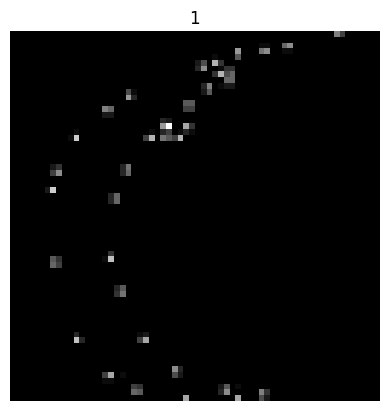

In [187]:
# drawing = train_dataset.__getitem__(260000) #Car
drawing = train_dataset.__getitem__(270014)

# print(drawing)
import matplotlib.pyplot as plt
print(drawing[0].shape)

# Visualize the image
plt.imshow(drawing[0].squeeze(), cmap='gray')  # Squeeze to remove the single channel dimension
plt.axis('off')  # Hide axis for better visualization
plt.title(drawing[1])
plt.show()

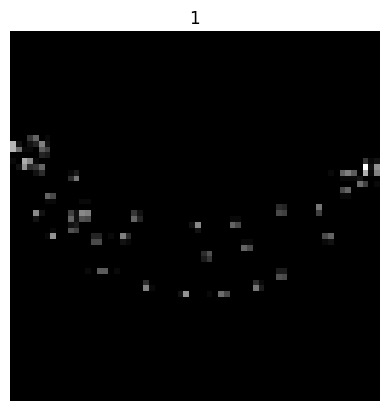

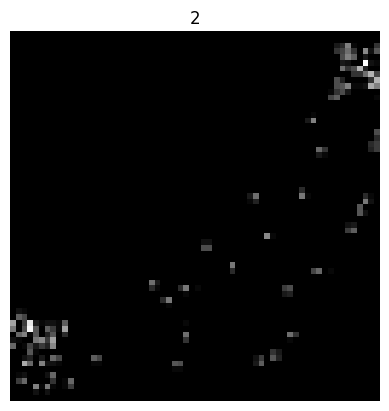

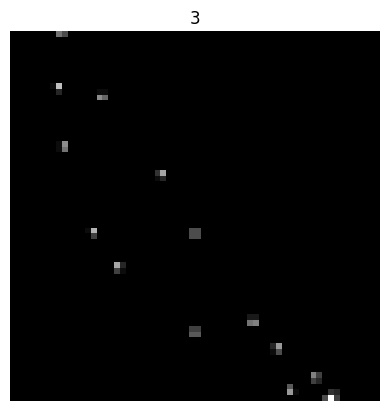

In [188]:
import numpy as np
import matplotlib.pyplot as plt

# Example input data (simplified vector data from the NDJSON)
drawings = [
    [[[4,18,29,63,93,120,146,169,186,218,244,234,186,154,128,86,44,14,0],[7,51,66,90,101,106,106,101,93,67,22,23,49,58,59,53,26,16,6]],[[10,27,42,78,135,162,212,230,244],[15,39,53,67,80,74,48,35,20]],[[9,2,16,22,23,20],[18,3,0,3,8,20]],[[229,244,254,252,241],[23,17,18,22,30]],[[52,52],[52,52]],[[52,50],[52,52]],[[59,43],[69,61]]],
    [[[223,226,227,233,254,255,248,227],[35,25,2,0,2,21,27,30]],[[234,235,244,246,249],[4,8,12,19,20]],[[232,208,168,135,98,37],[28,51,104,138,164,196]],[[255,255,245,194,182,172,115,26,18,8],[25,61,106,199,213,217,219,235,235,230]],[[12,1,0,0,10,22,29,28,16,11],[193,191,194,206,219,218,206,199,194,197]],[[41,29,12],[232,228,217]],[[7,7,12,14,14,18,19,23,27,29,37],[186,199,190,193,209,200,204,204,194,203,192]],[[230,230,235,238,241,245,245],[8,15,8,17,16,4,11]],[[251,251,241,235,211,191,121,59,31],[26,69,113,126,155,168,200,215,215]],[[214,201,177,153,120,108],[72,102,131,152,167,175]]], 
    [[[2,0,4,24,41,94,160,186,189,177,151,134,94,71,30],[0,38,79,138,162,207,247,255,251,238,218,200,139,98,45]]]
]

# Reconstruct the image from the simplified drawing
index = 0
for drawing in drawings:
    reconstructed_image = train_dataset.drawing_to_image(drawing)
    index+=1
    # Display the image
    plt.imshow(reconstructed_image, cmap='gray')
    plt.title(index)
    plt.axis('off')
    plt.show()

## Just a resizing test

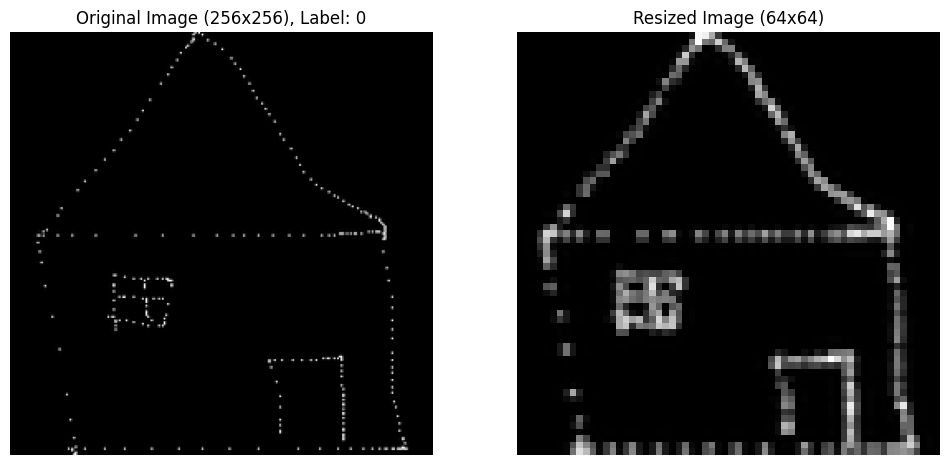

In [168]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T
import numpy as np
from PIL import Image

# Assuming `drawing` is the tuple as described
image_tensor = drawing[0]  # Image tensor of shape (1, H, W)
label = drawing[1]         # The label (in this case, 3)

image_numpy = image_tensor.squeeze().cpu().numpy()  # Shape: (H, W)
image_pil = Image.fromarray((image_numpy * 255).astype(np.uint8))  # Convert to uint8 image

# Resize using PIL
resized_image_pil = image_pil.resize((64, 64), Image.Resampling.LANCZOS)

# Convert back to NumPy (optional)
resized_image_numpy = np.array(resized_image_pil) / 255.0  # Normalize

# Plot original and resized image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original image
ax[0].imshow(image_numpy, cmap='gray')
ax[0].set_title(f"Original Image (256x256), Label: {label}")
ax[0].axis('off')

# Resized image
ax[1].imshow(resized_image_numpy, cmap='gray')
ax[1].set_title("Resized Image (64x64)")
ax[1].axis('off')

plt.show()

## Train and test algorithms

In [6]:
# Training loop
def train_model(model, optimizer, criterion):
    model.train()
    for epoch in range(num_epochs):  # Number of epochs
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

# Testing loop
def test_model(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {100 * correct / total:.2f}%")


## Model

In [190]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16*16, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

## Run the model

In [191]:
model = SimpleCNN().to(device)
print(next(model.parameters()).device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
print("model structure", model)

start_time = time.time()

train_model(model, optimizer, criterion)
test_model(model)

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")

cuda:0
model structure SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=12, bias=True)
  )
)
Epoch 1, Loss: 0.36464114999882846
Epoch 2, Loss: 0.2793513868731312
Epoch 3, Loss: 0.24580231722231982
Epoch 4, Loss: 0.22004315000631153
Epoch 5, Loss: 0.1977394068515854
Epoch 6, Loss: 0.17850245226462413
Epoch 7, Loss: 0.16114098512334682
Epoch 8, Loss: 0.14693802749813806
Epoch 9, Loss: 0.1344156533942808
Epoch 10, Loss: 0.12360996715897243
Accuracy: 89.78%
Exec

## Save the model

In [193]:
# Save the trained model to a file
model_file_path = "simple_model64.pth"
torch.save(model.state_dict(), model_file_path)
print(f"Model saved to {model_file_path}")

Model saved to simple_model64.pth


## Two other models

### Lighter

In [12]:
class EfficientCNN(nn.Module):
    def __init__(self, num_classes):
        super(EfficientCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # 1 input channel, 16 filters
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Reduce size by half
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 64),  # Fewer neurons in FC layer
            nn.ReLU(),
            nn.Linear(64, num_classes),
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x
    
lightModel = EfficientCNN(num_classes).to(device)
optimizer = optim.Adam(lightModel.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
print("lightModel structure", lightModel)

start_time = time.time()

train_model(lightModel, optimizer, criterion)
test_model(lightModel)

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")

lightModel structure EfficientCNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=12, bias=True)
  )
)


KeyboardInterrupt: 

### Deeper

In [7]:
from torch.optim import Adam, SGD, RMSprop
class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),  # Normalize feature maps for faster convergence
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Add a third convolutional layer
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),  # More neurons for higher capacity
            nn.ReLU(),
            nn.Dropout(0.5),  # Add dropout for regularization
            nn.Linear(256, num_classes),
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x
    
deepModel = EnhancedCNN().to(device)
# optimizer = optim.Adam(deepModel.parameters(), lr=learning_rate)
optimizer = SGD(deepModel.parameters(), lr=learning_rate, momentum=0.9)
criterion = nn.CrossEntropyLoss()
print("lightModel structure", deepModel)

lightModel structure EnhancedCNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=256, bias=True)
    (2):

In [ ]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import Adam, SGD, RMSprop

# Define the objective function for Optuna
def objective(trial):
    # Define the search space
    learning_rate = trial.suggest_categorical("learning_rate", 0.001, 0.0005)
    momentum = trial.suggest_categorical=["momentum", 0.9, 0.99, 0.5]
    
    # Initialize model
    model = EnhancedCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    
    optimizer = SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    
    # Training loop (simplified for Optuna)
    model.train()
    for epoch in range(3):  # Use a small number of epochs for quick evaluation
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    # Evaluation (simplified, using validation loss as metric)
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    
    return -total_loss  # Minimize validation loss

# Run Optuna Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=6)


print(study.best_params)
print(study.best_value)

[I 2025-02-12 17:16:25,261] A new study created in memory with name: no-name-cd9e1b50-210a-47c3-bbee-a32ad2accb09
/tmp/ipykernel_1648/4058461976.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-12 18:47:15,247] Trial 0 finished with value: -7349.272308028303 and parameters: {'learning_rate': 0.003980904145188189, 'optimizer': 'SGD'}. Best is trial 0 with value: -7349.272308028303.
[I 2025-02-12 20:10:22,363] Trial 1 finished with value: -10277.886927314103 and parameters: {'learning_rate': 0.0006821257345600005, 'optimizer': 'RMSprop'}. Best is trial 0 with value: -7349.272308028303.
[I 2025-02-12 21:44:05,513] Trial 2 finished with value: -7218.030352943577 and parameters: {'learning_rate': 0.00012022160650979998, 'optimizer': 'Adam'}. Best is

{'learning_rate': 0.0011682692580404393, 'optimizer': 'SGD'}
-7100.132679652423


In [23]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import Adam, SGD, RMSprop

# Define the objective function for Optuna
def objective2(trial):
    # Define the search space
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005])
    momentum = trial.suggest_categorical("momentum", [0.9, 0.99, 0.5])
    
    # Initialize model
    model = EnhancedCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    
    optimizer = SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    
    # Training loop (simplified for Optuna)
    model.train()
    for epoch in range(3):  # Use a small number of epochs for quick evaluation
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    # Evaluation (simplified, using validation loss as metric)
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    
    return -total_loss  # Minimize validation loss

# Run Optuna Study
study2 = optuna.create_study(direction="maximize")
study2.optimize(objective2, n_trials=6)


print(study2.best_params)
print(study2.best_value)
optuna.visualization.plot_optimization_history(study2)

[I 2025-02-13 12:39:18,413] A new study created in memory with name: no-name-3e8ff54f-e8e4-49a7-9f72-29b3f977d77f
[I 2025-02-13 14:13:30,850] Trial 0 finished with value: -7236.1364429099485 and parameters: {'learning_rate': 0.0005, 'momentum': 0.9}. Best is trial 0 with value: -7236.1364429099485.
[I 2025-02-13 15:45:33,800] Trial 1 finished with value: -7302.914536266588 and parameters: {'learning_rate': 0.0005, 'momentum': 0.9}. Best is trial 0 with value: -7236.1364429099485.
[W 2025-02-13 16:45:51,084] Trial 2 failed with parameters: {'learning_rate': 0.001, 'momentum': 0.99} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/quentin/BigData/.venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_64730/1486575523.py", line 24, in objective2
    for images, labels in train_loader:
  File "/home/quentin/BigData/.

KeyboardInterrupt: 

In [8]:
start_time = time.time()

train_model(deepModel, optimizer, criterion)
test_model(deepModel)

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")

# Save the trained model to a file
model_file_path = "final_model.pth"
torch.save(deepModel.state_dict(), model_file_path)
print(f"Model saved to {model_file_path}")

Epoch 1, Loss: 0.5981960058933914
Epoch 2, Loss: 0.4705312406810587
Epoch 3, Loss: 0.4356443354667346
Epoch 4, Loss: 0.41511178876122823
Epoch 5, Loss: 0.40138269837044027
Epoch 6, Loss: 0.3911075291577309
Epoch 7, Loss: 0.3823388489897702
Epoch 8, Loss: 0.37551491190459185
Epoch 9, Loss: 0.36954945308827797
Epoch 10, Loss: 0.36413811731490286
Accuracy: 90.56%
Execution time: 21996.449075 seconds
Model saved to final_model.pth


## Two deeper models

In [17]:
from torch.optim.lr_scheduler import StepLR

def train_model_with_scheduler(model, optimizer, scheduler, criterion, num_epochs=10):
    print(num_epochs)
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Update learning rate
        scheduler.step()
        
        # Print metrics
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
        for param_group in optimizer.param_groups:
            print(f"Learning Rate: {param_group['lr']}")


In [18]:
class ResNetLikeCNN(nn.Module):
    def __init__(self, num_classes):
        super(ResNetLikeCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Shortcut connection to match the channel dimensions
        self.shortcut = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=1, stride=1),  # Match input to output channels
            nn.BatchNorm2d(128)
        )

        self.pool = nn.AdaptiveAvgPool2d((8, 8))  # Ensure consistent spatial dimensions
        self.fc = None  # Placeholder, will be dynamically initialized
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))  # First convolution
        x = torch.relu(self.bn2(self.conv2(x)))  # Second convolution
        residual = self.shortcut(x)              # Adjust dimensions for residual
        x = torch.relu(self.bn3(self.conv3(x)) + residual)  # Add residual to output
        x = self.pool(x)  # Downsample to fixed size
        x = torch.flatten(x, 1)  # Flatten before fully connected layers
        x = self.fc(x)  # Fully connected layers
        return x

    def initialize_fc(self, input_shape):
        # Dynamically calculate the input size of the flattened feature map
        dummy_input = torch.zeros(input_shape)  # Create a dummy tensor with input shape
        conv_output = self.conv1(dummy_input)  # Pass through layers to determine flattened size
        conv_output = torch.relu(self.bn1(conv_output))
        conv_output = torch.relu(self.bn2(self.conv2(conv_output)))
        residual = self.shortcut(conv_output)
        conv_output = torch.relu(self.bn3(self.conv3(conv_output)) + residual)
        conv_output = self.pool(conv_output)
        flattened_size = torch.flatten(conv_output, 1).shape[1]  # Calculate flattened size
        
        # Define the fully connected layers dynamically
        self.fc = nn.Sequential(
            nn.Linear(flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

# Define number of classes and input shape
input_shape = (1, 1, 64, 64)  # Batch size of 1, 1 channel, 64x64 image size

# Instantiate the model and initialize fully connected layers
deeper1Model = ResNetLikeCNN(num_classes=num_classes)
deeper1Model.initialize_fc(input_shape)

# Move model to the device
deeper1Model = deeper1Model.to(device)

# Define optimizer, scheduler, and criterion
optimizer = optim.Adam(deeper1Model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
criterion = nn.CrossEntropyLoss()

# Print model structure
print("ResNetLikeCNN structure:")
print(deeper1Model)

# Training and testing
start_time = time.time()
train_model(deeper1Model, optimizer, scheduler, criterion, num_epochs)
test_model(deeper1Model)
end_time = time.time()

# Print execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")

# Save the trained model
model_file_path = "deeper1_model_dynamic.pth"
torch.save(deeper1Model.state_dict(), model_file_path)
print(f"Model saved to {model_file_path}")

ResNetLikeCNN structure:
ResNetLikeCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (shortcut): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool): AdaptiveAvgPool2d(output_size=(8, 8))
  (fc): Sequential(
    (0): Linear(in_features=8192, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=12, bias=True)
  )
)
Epoch [1/10], Loss: 0.5782
E

In [19]:
class DeeperCNN2(nn.Module):
    def __init__(self, num_classes):
        super(DeeperCNN2, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc1 = None  # Placeholder, will be initialized dynamically
        self.fc2 = nn.Linear(512, num_classes)  # Output layer for classification

    def forward(self, x):
        x = self.conv_layers(x)  # Pass through convolutional layers
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch size
        x = self.fc1(x)  # First fully connected layer
        x = self.fc2(x)  # Output layer
        return x

    def initialize_fc(self, input_shape):
        # Dynamically calculate the input size of the flattened feature map
        dummy_input = torch.zeros(input_shape)  # Create a dummy tensor with input shape
        conv_output = self.conv_layers(dummy_input)  # Pass through conv layers
        flattened_size = torch.flatten(conv_output, 1).shape[1]  # Calculate flattened size
        self.fc1 = nn.Linear(flattened_size, 512)  # Initialize fc1 with calculated size


input_shape = (1, 1, 64, 64)  # Batch size of 1, 1 channel, 64x64 image size

# Instantiate the model and initialize fully connected layer
deeper2Model = DeeperCNN2(num_classes=num_classes)
deeper2Model.initialize_fc(input_shape)

# Move model to the device
deeper2Model = deeper2Model.to(device)

# Define optimizer, scheduler, and criterion
optimizer = optim.Adam(deeper2Model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
criterion = nn.CrossEntropyLoss()

# Print model structure
print("DeeperCNN2 structure:")
print(deeper2Model)

# Training and testing
start_time = time.time()
train_model(deeper2Model, optimizer, scheduler, criterion, num_epochs)
test_model(deeper2Model)
end_time = time.time()

# Print execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")

# Save the trained model
model_file_path = "deeper2_model_dynamic.pth"
torch.save(deeper2Model.state_dict(), model_file_path)
print(f"Model saved to {model_file_path}")

DeeperCNN2 structure:
DeeperCNN2(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc2): Linear(in_features=512, out_features=12, bias=True)
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
)
Epoch [1/10], Loss: 0.4659
Epoch [2/10], Loss: 0.3979
Epoch [3/10], Loss: 0.3839
Epoch [4/10], Loss: 0.3762
Epoch [5/10], Loss: 0.3717
Epoch [6/10], Loss: 0.3676
Epoch [7/10], Loss: 0.3643
Epoch [8/10], Loss: 0.3627
Epoch [9/10], Loss: 0.3605
Epoch [10/10], Loss: 0.3589
Accuracy: 8

## Prediction

### The drawing

df    word countrycode                 timestamp  recognized key_id  \
0     0          FR  2025-01-17T10:37:48.061Z       False      0   
1     0          FR  2025-02-06T13:29:39.990Z       False      0   

                                             drawing  
0  [[[157, 158, 159, 161, 165, 169, 173, 175, 177...  
1  [[[110, 106, 99, 91, 83, 82, 81, 93, 105, 117,...  
prediction_dataset <__main__.QuickDrawDataset object at 0x7f2fe1000f80>
prediction_loader <torch.utils.data.dataloader.DataLoader object at 0x7f2fe05379e0>
(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), np.int64(0))
Shape :  torch.Size([1, 64, 64])


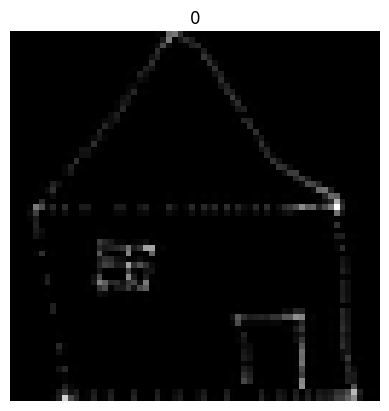

Shape :  torch.Size([1, 64, 64])


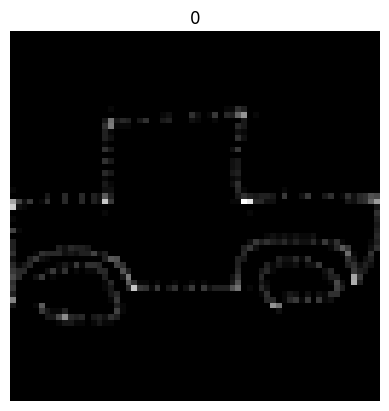

In [8]:
# drawing = [[[232,232,234,234,234,234,234,234,235,235,235,235,235,235,235,235,235,234,234,234,234,234,234,234,234,234,234,234,235,235,235,235,235,235,235,235,235,235,235,235,235,235,234],[393,395,395,396,397,398,400,401,401,402,403,405,406,407,408,410,411,411,412,413,415,416,418,420,421,422,423,425,425,426,427,428,430,431,432,433,435,436,437,438,440,441,441],[0,89,96,104,120,129,137,145,160,168,176,184,192,200,208,216,224,245,253,264,272,295,320,336,353,385,424,449,470,480,504,520,536,553,562,576,584,603,629,708,729,763,777]],[[248,248,249,249,249,249,249,249,250,250,250,250,250,250,250,250,250,250,250,250,250,250,250,250,250,250,249,249,249,250,250,250,250,250,250,250,250,251,251,251,251],[398,400,400,401,402,403,405,406,406,407,408,410,411,412,413,415,416,417,418,420,421,422,423,425,426,427,427,428,430,430,431,432,433,435,436,437,438,438,440,441,442],[1433,1545,1552,1561,1569,1577,1586,1600,1608,1616,1624,1644,1656,1677,1688,1711,1719,1745,1755,1778,1803,1811,1836,1849,1882,1905,1913,1936,1962,1986,2002,2027,2052,2084,2116,2187,2211,2219,2235,2261,2393]],[[251,252,254,255,255,256,256,257,259,259,258,258,257,256,256,256,254,254,253,253,252,251,251,249,249,248,248,247,247,246,244,244,243,242,241,241,239,238,238,237,237,236,236,234,234,233,232,232,231,229,229,228,227,227,226,226,224,223,223,224,225,226,226,227,229,229,230,231,232,232,234,235],[442,442,442,442,443,443,445,445,445,446,446,447,447,447,448,450,450,451,452,453,455,455,456,456,457,457,458,458,460,460,460,461,461,461,461,460,460,460,459,459,458,458,457,457,455,455,455,454,453,453,452,452,452,450,450,449,449,449,448,448,447,447,445,445,445,444,444,443,443,442,442,442],[2608,2693,2710,2736,2744,2752,2760,2769,2803,2810,3025,3065,3084,3112,3119,3161,3168,3247,3258,3274,3283,3322,3346,3449,3556,3584,3593,3618,3668,3683,3764,3796,3819,3881,3920,3928,3936,3959,3967,3979,3986,3995,4002,4010,4017,4025,4041,4050,4065,4092,4105,4125,4154,4178,4200,4209,4225,4273,4481,4488,4513,4545,4566,4576,4586,4592,4617,4649,4659,4666,4737,4833]],[[252,252,252,252,252,252,252,251,251],[402,400,399,398,397,395,394,394,393],[5699,5837,5866,5906,5924,5954,5986,6136,6180]],[[251,252,254,255,256,257,259,260,261,261,262,264,265,266,267,269,270,270,271,272,274,274,275,276,277,279,279,280,281,281,281,282,282,284,284,283,282,282,281,279,278,277,277,276],[393,393,393,393,393,393,393,393,393,392,392,392,392,392,392,392,392,390,390,389,389,388,388,385,385,384,383,383,382,380,379,379,378,378,377,377,377,375,375,374,374,374,373,373],[6776,6904,6945,6964,6973,6985,6993,7001,7023,7059,7065,7073,7081,7106,7154,7161,7181,7189,7197,7250,7257,7280,7289,7297,7305,7314,7328,7336,7355,7427,7434,7441,7449,7457,7481,7764,7772,7787,7797,7822,7847,7858,7866,7914]],[[276,276,276,276,274,273,273,272,272,271,271,272,274,274,275,275,274,273,272,271,269,269,268,268,268,268,267,266,266,266,264,264,264,263,263,262,262,261,259,258,258,257,256,256,254,253,252,251,249,248,247,246,244,243,243,242,241,239,238,237,232,227,226,224,223,222,221,219,218,217,217,216,214,213,213,212,212,211,208,208,207,207,207,209,209,210,210,209,209,208,207,206,206,207,209,209,210,211,211,211,211,211,211,212,212,214,215,216,216,217,219,219,220,221,221,222,222,224,224,225,226,227,229,230,231,232,234,235],[373,372,370,369,369,369,368,368,367,367,365,364,364,363,363,362,360,360,359,359,359,358,358,360,361,362,362,362,363,365,365,366,367,367,368,368,370,370,370,371,372,372,372,373,373,373,373,373,375,375,375,375,375,374,375,375,375,376,376,376,376,376,376,376,376,376,376,376,375,375,374,374,373,373,372,372,370,370,370,371,371,372,373,373,375,375,376,376,377,377,377,377,378,378,378,380,380,380,381,382,383,385,386,386,387,387,387,387,388,388,388,390,390,390,391,391,392,392,393,393,393,393,393,393,393,393,393,393],[8768,9048,9137,9448,9497,9537,9545,9560,9568,9586,9595,9977,9988,10105,10112,10120,10417,10473,10479,10544,10576,10587,10977,10985,11000,11057,11064,11088,11099,11119,11127,11163,11172,11179,11202,11218,11244,11252,11265,11273,11298,11306,11327,11335,11344,11352,11364,11396,11419,11427,11482,11510,11521,11530,11537,11546,11553,11561,11569,11577,11585,11593,11601,11610,11618,11666,11714,11754,11810,11818,11850,11876,11890,11897,11904,11912,11920,11928,12026,12761,12833,12900,13216,13273,13337,13344,13366,13588,13617,13756,13848,13864,14016,14073,14088,14112,14119,14141,14208,14377,14409,14472,14521,14745,14765,14773,14825,14848,14856,14872,14913,14953,14973,15016,15051,15082,15090,15130,15145,15173,15211,15234,15293,15315,15340,15379,15445,15465]],[[232,234,235,236,237,239,240,241,242,244,245,246,247,249,250,251,252],[397,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397,397],[16944,17136,17153,17178,17191,17248,17270,17295,17344,17376,17409,17428,17475,17495,17506,17581,17674]],[[234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234],[377,375,374,373,372,370,369,368,367,365,364,363,362,360,359,358,357,355,354],[20138,20306,20339,20368,20378,20403,20427,20451,20483,20506,20534,20547,20576,20603,20626,20635,20642,20657,20676]],[[252,251,251,251,251,249,249,249,249,249,249,249,249,248,248,248,248,249,249,249,249,249],[376,375,374,373,372,372,370,369,368,367,365,364,363,363,362,360,359,359,358,357,355,354],[22167,22267,22274,22299,22314,22330,22338,22358,22370,22399,22442,22465,22522,22541,22553,22586,22661,22682,22715,22738,22787,22808]],[[234,234,233,233,232,231,231,229,228,228,227,227,226,224,224,224,225,225,226,226,226,226,227,229,229,230,230,231,231],[355,354,354,353,353,352,350,350,350,349,349,348,348,348,347,345,344,343,342,340,339,338,337,337,335,335,334,334,333],[23498,23619,23648,23656,23665,23689,23722,23756,23764,23777,23798,23834,23868,23889,24072,24097,24122,24135,24160,24200,24248,24272,24570,24577,24618,24666,24688,24697,24713]],[[252,252,252,254,254,255,255,256,257,257,259,258,258,258,258,258,258,258,258,258,257,257,256,254,253,253,252],[355,354,353,353,352,352,350,350,350,349,349,349,348,347,345,344,343,342,340,339,339,338,338,338,338,337,337],[25599,25800,25807,25832,25854,25864,25921,25928,25953,25962,25991,26291,26299,26323,26347,26371,26395,26435,26454,26479,26744,26761,26776,26824,26865,26963,26987]],[[232,232,232,232,232,232,232,232,232,232,232,232,232,232,232,232,232,232,232,232,232,232,232,232,231,231,231,231,231,231,231,231,231,229,229,229,229,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,231,231,231,231,231,231,231,232,232,232,232,232,232,232,234,234,234,235,235,236,236,236,237,237,239,238,239,240,240,241],[334,333,332,330,329,328,327,325,324,323,322,320,319,318,317,315,314,313,312,310,309,308,307,305,305,304,303,302,297,295,294,293,292,292,287,285,284,284,283,282,280,279,278,277,275,274,273,272,270,269,268,267,265,265,264,263,262,260,259,258,258,257,255,254,253,252,250,250,249,248,248,247,247,245,244,244,243,243,242,242,242,240,240],[27727,27872,27896,27936,27960,27985,27999,28024,28031,28088,28136,28167,28188,28210,28244,28258,28268,28277,28285,28347,28368,28376,28417,28428,28435,28443,28451,28460,28468,28476,28510,28518,28577,28591,28599,28624,28631,28639,28647,28680,28687,28694,28717,28726,28776,28791,28817,28826,28866,28922,28955,28986,29011,29018,29061,29085,29115,29143,29154,29244,29251,29259,29284,29309,29322,29351,29379,29451,29466,29515,29543,29551,29563,29584,29620,29634,29754,29761,29769,29777,29801,29849,29883]],[[256,256,256,256,256,256,256,256,256,254,254,254,254,254,253,253,253,253,253,253,253,253,253,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,251,251,251,251,251,249,249,249,249,249,249,249,249,249,249,249,249,249,249,249,249,249,249,248,248,248,248,248,248,248,248,248,247,247,247,247,246,246,246,246,246,246,246,246,244,243,243,242,241,239],[340,339,338,337,335,334,333,332,330,330,329,328,327,325,325,324,323,322,320,319,318,317,315,314,313,312,310,309,308,307,305,304,303,302,300,299,298,297,295,295,294,293,292,290,289,288,287,285,284,283,282,280,279,278,277,275,274,273,272,270,269,268,268,267,265,264,263,262,260,259,258,258,257,255,254,254,253,252,250,249,248,247,245,245,245,244,244,244,244],[31199,31256,31283,31323,31347,31366,31391,31399,31424,31449,31474,31482,31498,31515,31524,31532,31546,31565,31590,31615,31625,31648,31657,31682,31691,31704,31723,31748,31759,31781,31806,31815,31840,31872,31896,31914,31927,31952,31976,31983,32006,32015,32040,32056,32081,32095,32120,32127,32151,32173,32186,32207,32235,32266,32291,32315,32330,32416,32439,32448,32464,32496,32528,32535,32556,32581,32608,32631,32655,32680,32712,32739,32747,32760,32781,32792,32800,32822,32830,32839,32847,32855,32864,33000,33022,33047,33055,33112,33123]],[[108],[115],[43729]]]
import ujson as json

# df = download_data_and_parse_it("data/prediction.json")
destination_path = "data/prediction.json"
if os.path.exists(destination_path):
    with open(destination_path, "r", encoding="utf-8") as f:
                df = pd.DataFrame.from_records(json.load(f))

print("df",df)
prediction_dataset = QuickDrawDataset(df["drawing"], df["word"], resize_to=(64, 64))
print("prediction_dataset",prediction_dataset)
prediction_loader = DataLoader(prediction_dataset, batch_size=1, shuffle=True)
print("prediction_loader",prediction_loader)
drawing = prediction_dataset.__getitem__(0)
drawing2 = prediction_dataset.__getitem__(1)

print(prediction_loader.dataset[0])
print("Shape : ", drawing[0].shape)
plt.imshow(drawing[0].squeeze(), cmap='gray')  # Squeeze to remove the single channel dimension
plt.axis('off')  # Hide axis for better visualization
plt.title(drawing[1])
plt.show()
print("Shape : ", drawing2[0].shape)
plt.imshow(drawing2[0].squeeze(), cmap='gray')  # Squeeze to remove the single channel dimension
plt.axis('off')  # Hide axis for better visualization
plt.title(drawing2[1])
plt.show()

### The prediction

In [10]:
from torchvision.transforms import ToTensor

# reconstructed_image = prediction_dataset.drawing_to_image(drawing)
# plt.imshow(reconstructed_image, cmap='gray')
# plt.axis('off')
# plt.show()

model = EnhancedCNN().to(device)
model.load_state_dict(torch.load("deepest_model64.pth", map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode

# # Prepare the input image
# # Assuming reconstructed_image is a PIL Image
# transform = ToTensor()  # Convert PIL image to tensor
# input_image = transform(reconstructed_image).unsqueeze(0)  # Add batch dimension

# Make prediction
with torch.no_grad():  # No need to compute gradients for inference
    for images, labels in prediction_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        # print(output)
        predicted_class = word_class_mapping[torch.argmax(output, dim=1).item()]
        print(f"Predicted Class: {predicted_class}")

# Print the result


/tmp/ipykernel_79495/4260353792.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("deepest_model64.pth", map_location=torch.device('cpu'))

FileNotFoundError: [Errno 2] No such file or directory: 'deepest_model64.pth'

In [9]:
model = EnhancedCNN().to(device)
model.load_state_dict(torch.load("final_model.pth", map_location=torch.device('cpu'), weights_only=True))
model.eval()  # Set the model to evaluation mode

def predict_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    model = model.to(device)  # Move the model to the correct device
    predictions = []
    true_labels = []
    
    with torch.no_grad():  # Disable gradient calculation for inference
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the same device
            outputs = model(images)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
            
            predictions.extend(predicted.cpu().numpy())  # Collect predictions
            true_labels.extend(labels.cpu().numpy())    # Collect true labels (optional)
    
    return predictions, true_labels



predictions, true_labels = predict_model(model, test_loader, device)

from sklearn.metrics import accuracy_score, classification_report

print(f"Accuracy: {accuracy_score(true_labels, predictions)}")
print(classification_report(true_labels, predictions))


Accuracy: 0.9056077539928309
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     29051
           1       0.89      0.92      0.91     61411
           2       0.89      0.91      0.90     25865
           3       0.94      0.95      0.95     25256
           4       0.94      0.95      0.94     36420
           5       0.84      0.81      0.82     24571
           6       0.74      0.84      0.79     30525
           7       0.83      0.81      0.82     25193
           8       0.94      0.91      0.92     26944
           9       0.92      0.94      0.93     23984
          10       0.87      0.88      0.88     23938
          11       0.94      0.94      0.94     27163
          12       0.95      0.94      0.94     24589
          13       0.85      0.79      0.82     24391
          14       0.90      0.89      0.90     24526
          15       0.93      0.93      0.93     27049
          16       0.94      0.91      0.93     2743